In [1]:
# ==============================================================================
# SCRIPT TO CALCULATE AND PLOT FIGURE 1: THE WARMING PHENOMENON
#
# This script performs the following actions:
# 1. Defines thermodynamic constants and functions for a moist atmosphere.
# 2. Implements a function to calculate a moist adiabatic temperature profile
#    by conserving Moist Static Energy (MSE) at each vertical step.
# 3. Runs this function for a range of surface temperatures (Ts) and for
#    a perturbed state (Ts + 4K) to compute the warming profile (Delta T).
# 4. Processes the results to generate data for three key plots.
# 5. Creates Figure 1, a three-panel plot showing:
#    (a) The change in column-integrated moisture vs. surface temperature.
#    (b) The vertical profiles of warming (Delta T) for different surface temperatures.
#    (c) The non-monotonic warming at fixed heights vs. surface temperature.
# ==============================================================================

# For sharper inline plots in Jupyter environments
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy import constants
from scipy.interpolate import interp1d
import time

# --- Physical Constants ---
g = constants.g
cpd = 1005.7
Rd = 287.05
Rv = 461.5
epsilon = Rd / Rv
P0 = 100000.0
Lv_const = 2.501e6

# --- Thermodynamic Functions ---

def saturation_vapor_pressure(T):
    """
    Calculates saturation vapor pressure (es) over liquid water using the
    formula from Bolton (1980) (in Pa).
    """
    T_celsius = T - 273.15
    es_hPa = 6.112 * np.exp((17.67 * T_celsius) / (T_celsius + 243.5))
    return es_hPa * 100.0

def saturation_specific_humidity(p, T):
    """Calculates saturation specific humidity (qs) over water (kg/kg)."""
    es = saturation_vapor_pressure(T)
    es = np.minimum(es, p * 0.99)
    p_minus_es_approx = p - (1.0 - epsilon) * es
    denominator = np.maximum(p_minus_es_approx, 1e-3)
    qs = epsilon * es / denominator
    return np.maximum(qs, 0.0)

def calculate_mse(T, p, z):
    """
    Calculates Moist Static Energy (MSE) using the approximation
    MSE = cpd*T + g*z + Lv*qs (J/kg).
    """
    qs = saturation_specific_humidity(p, T)
    mse = cpd * T + g * z + Lv_const * qs
    return mse

def virtual_temperature(T, p):
    """Calculates virtual temperature (Tv) assuming saturation."""
    qs = saturation_specific_humidity(p, T)
    Tv = T * (1.0 + (1.0 / epsilon - 1.0) * qs)
    return np.maximum(Tv, 10.0)

# --- Profile Calculation Function ---

def calculate_moist_adiabatic_profile(T_surf, p_surf, z_max, dz):
    """
    Calculates temperature and pressure profiles by conserving MSE.
    Returns z, T, and p profiles.
    """
    n_steps = int(z_max / dz) + 1
    z_profile = np.linspace(0, z_max, n_steps)
    T_profile = np.full(n_steps, np.nan)
    p_profile = np.full(n_steps, np.nan)

    T_profile[0] = T_surf
    p_profile[0] = p_surf
    mse_conserved = calculate_mse(T_profile[0], p_profile[0], 0.0)

    for i in range(n_steps - 1):
        z_curr, T_curr, p_curr = z_profile[i], T_profile[i], p_profile[i]
        z_next = z_profile[i+1]

        if np.isnan(T_curr) or p_curr <= 0:
            break

        Tv_curr = virtual_temperature(T_curr, p_curr)
        scale_height = (Rd * Tv_curr) / g
        p_next = p_curr * np.exp(-dz / scale_height)
        if p_next <= 0:
            break

        def mse_residual(T_guess):
            return calculate_mse(T_guess, p_next, z_next) - mse_conserved

        try:
            bracket = [50.0, T_curr]
            if mse_residual(bracket[0]) * mse_residual(bracket[1]) > 0:
                break
            sol = root_scalar(mse_residual, bracket=bracket, method='brentq', xtol=1e-3)
            if sol.converged:
                T_profile[i+1] = sol.root
                p_profile[i+1] = p_next
            else:
                break
        except (ValueError, RuntimeError):
            break

    valid_indices = ~np.isnan(T_profile)
    return z_profile[valid_indices], T_profile[valid_indices], p_profile[valid_indices]

# --- Main Calculation Block ---
print("--- Starting Main Calculation ---")
start_time = time.time()

# Parameters
T_surf_values = np.arange(280, 320.1, 2.0)
p_surf_pa = 100000.0
z_max_m = 25000.0
dz_m = 100.0
delta_T_surf = 4.0

profiles = {}
for T_surf in T_surf_values:
    print(f"Processing Ts = {T_surf:.1f} K...")
    z1, T1, p1 = calculate_moist_adiabatic_profile(T_surf, p_surf_pa, z_max_m, dz_m)
    z2, T2, p2 = calculate_moist_adiabatic_profile(T_surf + delta_T_surf, p_surf_pa, z_max_m, dz_m)

    if z1 is not None and len(z1) > 2 and z2 is not None and len(z2) > 2:
        profiles[T_surf] = {'base': {'z': z1, 'T': T1, 'p': p1}, 'pert': {'z': z2, 'T': T2, 'p': p2}}
    else:
        print(f" -> Failed to generate complete profiles for Ts = {T_surf:.1f} K.")

print(f"\n--- Calculation Finished in {time.time() - start_time:.2f} seconds ---\n")

# --- Data Processing for Plots ---
print("--- Processing Data for Figure 1 ---")
z_grid_m = np.arange(0, 20001, dz_m)
delta_q_total = {}
delta_T_on_z = {}

for T_surf, data in profiles.items():
    interp_T1_z = interp1d(data['base']['z'], data['base']['T'], kind='linear', bounds_error=False, fill_value=np.nan)
    interp_T2_z = interp1d(data['pert']['z'], data['pert']['T'], kind='linear', bounds_error=False, fill_value=np.nan)
    interp_p1_z = interp1d(data['base']['z'], data['base']['p'], kind='linear', bounds_error=False, fill_value=np.nan)
    interp_p2_z = interp1d(data['pert']['z'], data['pert']['p'], kind='linear', bounds_error=False, fill_value=np.nan)

    T1_z = interp_T1_z(z_grid_m)
    T2_z = interp_T2_z(z_grid_m)
    p1_z = interp_p1_z(z_grid_m)
    p2_z = interp_p2_z(z_grid_m)

    delta_T_on_z[T_surf] = T2_z - T1_z

    qs1 = saturation_specific_humidity(p1_z, T1_z)
    qs2 = saturation_specific_humidity(p2_z, T2_z)
    valid_mask = ~np.isnan(qs1) & ~np.isnan(qs2)
    q_total_base = np.trapz(qs1[valid_mask], z_grid_m[valid_mask])
    q_total_pert = np.trapz(qs2[valid_mask], z_grid_m[valid_mask])
    delta_q_total[T_surf] = q_total_pert - q_total_base


--- Starting Main Calculation ---
Processing Ts = 280.0 K...
Processing Ts = 282.0 K...
Processing Ts = 284.0 K...
Processing Ts = 286.0 K...
Processing Ts = 288.0 K...
Processing Ts = 290.0 K...
Processing Ts = 292.0 K...
Processing Ts = 294.0 K...
Processing Ts = 296.0 K...
Processing Ts = 298.0 K...
Processing Ts = 300.0 K...
Processing Ts = 302.0 K...
Processing Ts = 304.0 K...
Processing Ts = 306.0 K...
Processing Ts = 308.0 K...
Processing Ts = 310.0 K...
Processing Ts = 312.0 K...
Processing Ts = 314.0 K...
Processing Ts = 316.0 K...
Processing Ts = 318.0 K...
Processing Ts = 320.0 K...

--- Calculation Finished in 0.50 seconds ---

--- Processing Data for Figure 1 ---


/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_72600/583609494.py:165: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  q_total_base = np.trapz(qs1[valid_mask], z_grid_m[valid_mask])
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_72600/583609494.py:166: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  q_total_pert = np.trapz(qs2[valid_mask], z_grid_m[valid_mask])


--- Generating Figure 1 ---


<>:28: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:48: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:28: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
<>:48: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_72600/562151262.py:28: SyntaxWarning: "\D" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\D"? A raw string is also an option.
  ax2.set_xlabel('Warming $\Delta T$ (K)')
/var/folders/1p/qh999ffj1s16918rzwp10h4h0000gn/T/ipykernel_72600/562151262.py:48: SyntaxWarning: "\D" is an inva

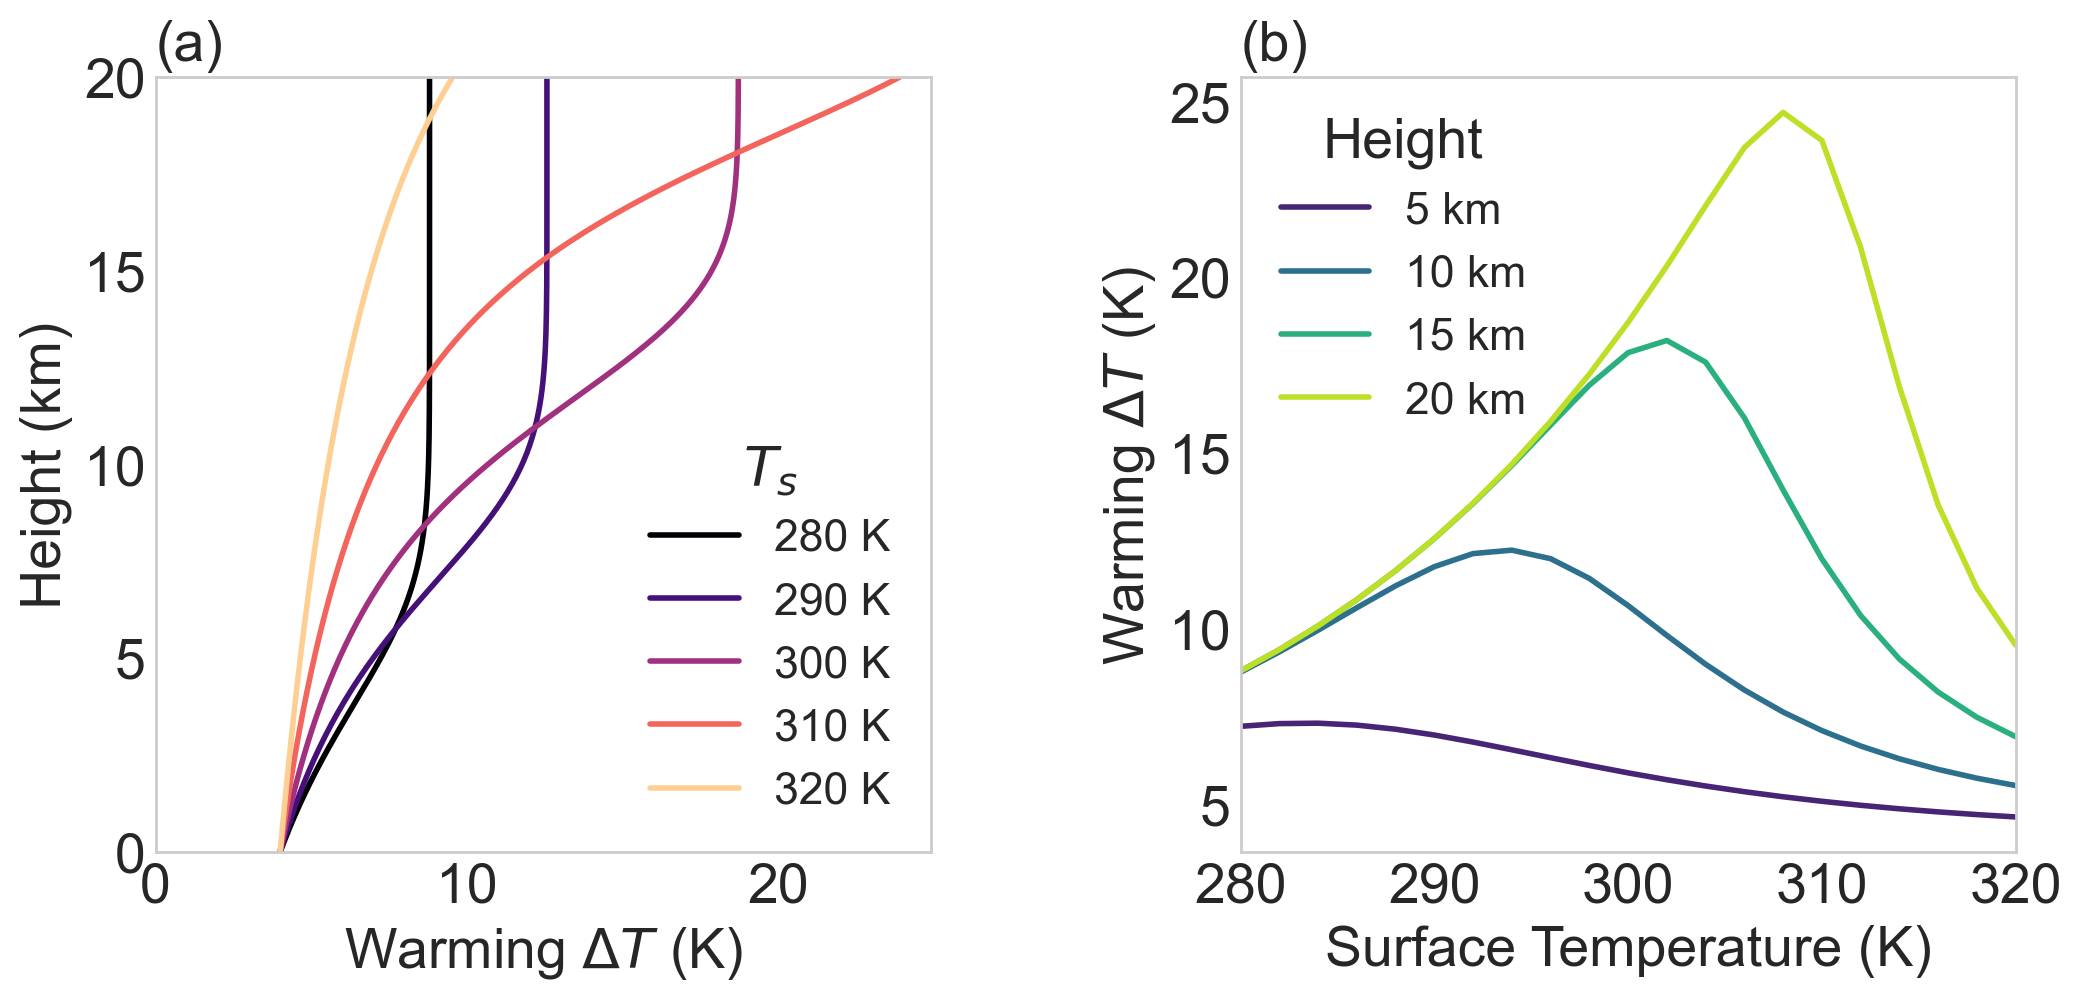

Figure A1 saved as fig-a1.png

Script finished.


In [2]:
# --- Plotting Figure 1 ---
print("--- Generating Figure 1 ---")
plt.style.use('seaborn-v0_8-whitegrid')

# Set global font size for all plot elements
base_fontsize = 20
plt.rcParams.update({
    'font.size': base_fontsize,
    'axes.titlesize': base_fontsize,
    'axes.labelsize': base_fontsize,
    'xtick.labelsize': base_fontsize,
    'ytick.labelsize': base_fontsize,
    'legend.fontsize': base_fontsize-4,
    'figure.titlesize': base_fontsize + 2
})

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
cmap_b = plt.get_cmap('magma')
cmap_c = plt.get_cmap('viridis')

# Panel (b): Vertical Warming Profiles
ax2 = axes[0]
T_plot_values = np.arange(280, 320.1, 10.0)
colors_b = cmap_b(np.linspace(0, 0.9, len(T_plot_values)))
for i, T_surf in enumerate(T_plot_values):
    if T_surf in delta_T_on_z:
        ax2.plot(delta_T_on_z[T_surf], z_grid_m / 1000.0, color=colors_b[i], label=f'{T_surf:.0f} K', linewidth=2)
ax2.set_xlabel('Warming $\Delta T$ (K)')
ax2.set_ylabel('Height (km)')
ax2.set_title('(a)', ha='left', x=0.0)
ax2.legend(title='$T_{s}$', loc='lower right')
ax2.grid(False)
ax2.set_ylim(0, 20)
ax2.set_xlim(left=0)
ax2.set_box_aspect(1)

# Panel (c): Non-Monotonic Warming at Fixed Heights
ax3 = axes[1]
z_levels_km = [5, 10, 15, 20]
colors_c = cmap_c(np.linspace(0.1, 0.9, len(z_levels_km)))
sorted_surfs = sorted(delta_q_total.keys())
for i, z_km in enumerate(z_levels_km):
    z_idx = np.argmin(np.abs(z_grid_m - z_km * 1000.0))
    valid_surfs = [T for T in sorted_surfs if T in delta_T_on_z and z_idx < len(delta_T_on_z[T]) and np.isfinite(delta_T_on_z[T][z_idx])]
    warming_at_z = [delta_T_on_z[T][z_idx] for T in valid_surfs]
    ax3.plot(valid_surfs, warming_at_z, linestyle='-', color=colors_c[i], label=f'{z_km} km', linewidth=2)
ax3.set_xlabel('Surface Temperature (K)')
ax3.set_ylabel('Warming $\Delta T$ (K)')
ax3.set_title('(b)', ha='left', x=0.0)
ax3.legend(title='Height', loc='upper left')
ax3.grid(False)
ax3.set_xlim(280, 320)
ax3.set_box_aspect(1)

plt.subplots_adjust(wspace=0.4)
figa1_filename = "fig-a1.png"
plt.savefig(figa1_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"Figure A1 saved as {figa1_filename}")

print("\nScript finished.")
